### Setup and Load Data

In [13]:
!pip install tensorflow opencv-python matplotlib

In [1]:
import tensorflow as tf
import os # Navigating through file structures
import cv2
import imghdr

data_dir = '/Users/AyaHourani 1/Desktop/Data'
image_exts = ['jpeg', 'jpg', 'bmp', 'png'] # Image extensions

for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('image not in ext list{}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))


2023-12-12 19:14:20.911646: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Load Data

In [2]:
import numpy as np
from matplotlib import pyplot as plt

# Building data pipeline and reshaping images
data = tf.keras.utils.image_dataset_from_directory('/Users/AyaHourani 1/Desktop/Data')
# Access loop from data pipeline
data_iterator = data.as_numpy_iterator()
# 32 images per batch (see doc for more info)
batch = data_iterator.next()
# Images represented as numpy arrays
#batch[1]

Found 200 files belonging to 2 classes.


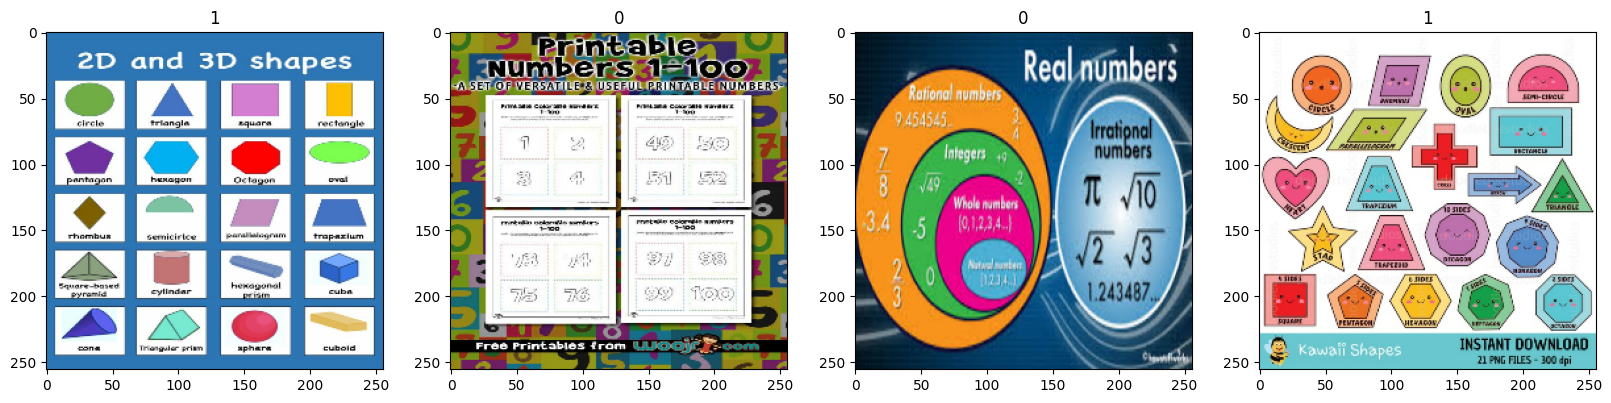

In [3]:
# Visualizing the images
# Class 0 = numbers
# Class 1 = shapes
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

### Preprocessing Data

In [4]:
# Scale Data
data = data.map(lambda x,y: (x/255, y)) # Performs transformation in pipeline

scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()
# batch[0].max()


In [5]:
# Split Data
train_size = int(len(data)*0.7) # 4 batches for training
val_size = int(len(data)*0.2) + 1 # 2 batches for validation
test_size = int(len(data)*0.1) + 1 # 1 batch for test

# Establishing partitions
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

### Building the Deep Learning Model

In [6]:
# Build Deep Learning Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
# We're using the CNN Architecture, great for image classification
# MaxPooling condenses values and returns max values

model = Sequential()

# Adding the layers to the network
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

# Condense rows and width and # of channels
model.add(Flatten())

# Fully connected layers
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


In [7]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

### Training

In [9]:
logdir = '/Users/AyaHourani 1/Desktop/Logs'
# Log model training as it trains
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])


Epoch 1/20
4/4 [==============================] - 6s 1s/step - loss: 1.7770 - accuracy: 0.5859 - val_loss: 1.4475 - val_accuracy: 0.4688
Epoch 2/20
4/4 [==============================] - 4s 955ms/step - loss: 0.9514 - accuracy: 0.4609 - val_loss: 0.7400 - val_accuracy: 0.4375
Epoch 3/20
4/4 [==============================] - 4s 938ms/step - loss: 0.6947 - accuracy: 0.5078 - val_loss: 0.6660 - val_accuracy: 0.6875
Epoch 4/20
4/4 [==============================] - 4s 932ms/step - loss: 0.6580 - accuracy: 0.6641 - val_loss: 0.6649 - val_accuracy: 0.5469
Epoch 5/20
4/4 [==============================] - 4s 944ms/step - loss: 0.6600 - accuracy: 0.5859 - val_loss: 0.6229 - val_accuracy: 0.6094
Epoch 6/20
4/4 [==============================] - 4s 947ms/step - loss: 0.5860 - accuracy: 0.7422 - val_loss: 0.5417 - val_accuracy: 0.8281
Epoch 7/20
4/4 [==============================] - 4s 943ms/step - loss: 0.5487 - accuracy: 0.7500 - val_loss: 0.5077 - val_accuracy: 0.7500
Epoch 8/20
4/4 [=======

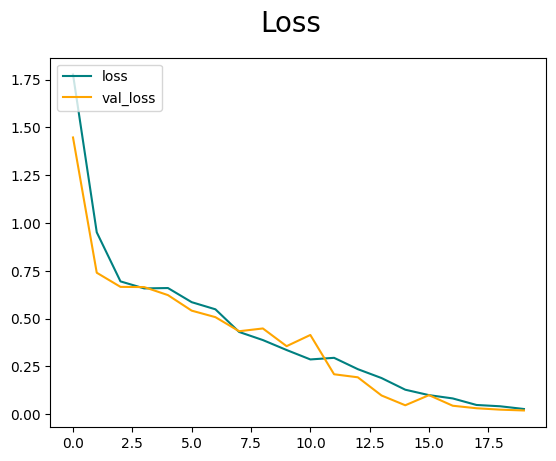

In [10]:
# Plot Performance
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

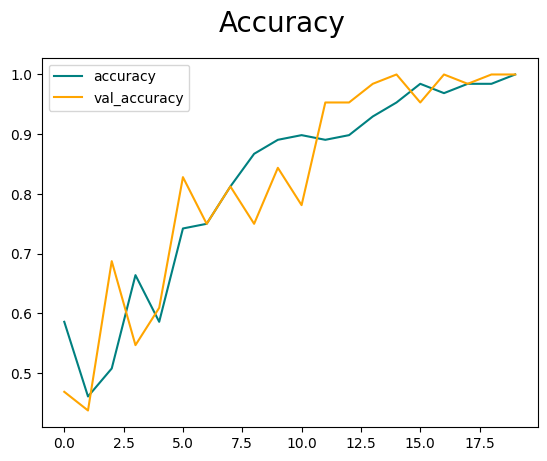

In [11]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

### Evaluate Performance

In [12]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

pre_metric = Precision()
recall_metric = Recall()
acc_metric = BinaryAccuracy()

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre_metric.update_state(y, yhat)
    recall_metric.update_state(y, yhat)
    acc_metric.update_state(y, yhat)
    
print(f'Precision:{pre_metric.result().numpy()}, Recall:{recall_metric.result().numpy()}, Accuracy:{acc_metric.result().numpy()}')

1/1 [==============================] - 0s 127ms/step
Precision:1.0, Recall:1.0, Accuracy:1.0


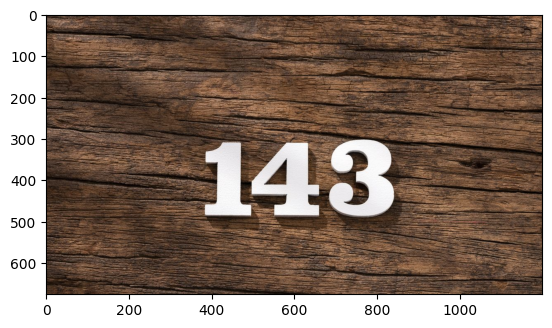

In [13]:
# Test
import cv2

img = cv2.imread('/Users/AyaHourani 1/Desktop/numbers_test.jpeg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()


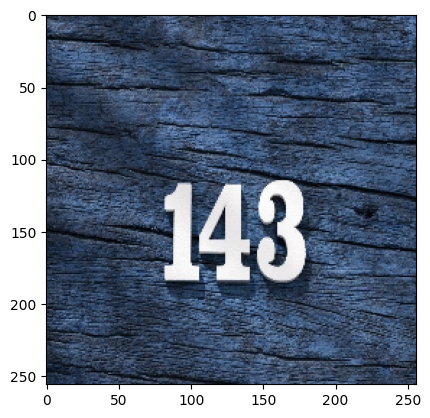

In [14]:
# Resize
resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [15]:
np.expand_dims(resize, 0)
yhat = model.predict(np.expand_dims(resize/255, 0))
yhat

1/1 [==============================] - 0s 23ms/step


array([[0.03178492]], dtype=float32)

In [16]:
if yhat > 0.5:
    print(f'Predicted class is a shape')
else:
    print(f'Predicted class is a number')

Predicted class is a number


### Saving the Model

In [18]:
from tensorflow.keras.models import load_model

model.save('imageclassifer_model.h5')
